In [1]:
import csv
import cv2
import numpy as np

def load_log():
    """Returns the training set, x_train and y_train, from the specified csv file"""
    rows = []
    with open('./sim/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            rows.append(row)   

    images = []
    measurements = []    
    correction = 0.1
    
    for row in rows:
        #First (0.) column in excel, center image
        for column in range(3):
            source_path = row[column]
            tokens = source_path.split('/')
            filename = tokens[-1]    
            local_path = './sim/IMG/'+filename
            #Image processing
            image = cv2.imread(local_path)
            images.append(image)
            
        #4th (3) column in excel, measure corr. to center image
        measurement = float(row[3])
        measurements.append(measurement)
        measurements.append(measurement+correction)
        measurements.append(measurement-correction)
        
    return {'images': np.array(images), 'measurements': np.array(measurements)}
    
def augment_dataset(images, measurements):    
    """augments the training data with mirrored images. Returns a tuple"""
    aug_images = []
    aug_measurements = []
    
    for img, mes in zip(images, measurements):
        aug_images.append(img)
        aug_measurements.append(mes)
        
        flipped_img = cv2.flip(img,1)
        flipped_mes = mes * -1.0
        
        aug_images.append(flipped_img)
        aug_measurements.append(flipped_mes)
    
    return np.array(aug_images), np.array(aug_measurements)

In [2]:
x_train, y_train = augment_dataset(load_log()['images'], load_log()['measurements'])
print(len(x_train))
print(len(y_train))

1836
1836


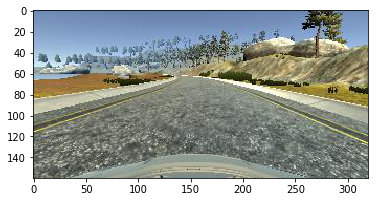

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.cvtColor(x_train[300], cv2.COLOR_BGR2RGB)
plt.imshow(img)




In [4]:
print(x_train.shape[1],x_train.shape[2],x_train.shape[3])
print(x_train.shape[3:4], x_train.shape[1:3])


160 320 3
(3,) (160, 320)


In [6]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Lambda, Convolution2D, MaxPooling2D, AveragePooling2D


my_shape= x_train.shape[1:4]
#architecture of the model
model = Sequential()
model.add(Lambda(lambda x: x/255.0-0.5, input_shape = my_shape))
#NB! Convolutions2D(samples, channels, rows, cols)
model.add(Convolution2D(6,5,5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(16,5,5, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(80))
model.add(Dense(1))

model.add(Flatten())
model.add(Dense(1))

#
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(x_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model.h5')


Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 33s - loss: 3.1491 - acc: 0.1029 - val_loss: 0.1721 - val_acc: 0.2092

KeyboardInterrupt: 